# BL40A2020 Wireless Communication Systems

## Assignment  week 6: Channel coding and information theory

## Author: Vili Raunola

### 1. Follow similar steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%206/week6.ipynb) to analyze the *[Binary erasure channel](https://komm.readthedocs.io/en/latest/komm.BinaryErasureChannel/)* 

![](https://upload.wikimedia.org/wikipedia/commons/b/b6/Binary_erasure_channel.svg)

**(a) Find the analytical error probability for a repetition code with size $n$ as a function of  $p$ considering that 0 and 1 are equally distributed?**

Hint: Remember that the only way to get an error in this scenario is to have all $n$ bits in the coded block wrong.

The only way to get the error is that the received bit array is full of errors. This means that sending each bit would lead to an error state. So sending n amount of bits which all would lead to an error is F(p)=p^n. If even one of the bits in the bit array is correct we can know what the original bit is supposed to be since 0 can't be converted to 1 in the channel or vice versa. 


**(b) Verify your results with simulation for a repetition code of $n=6$ and $p=0.4$.** 

Hint: You need to program/adapt the decoding. The komm decoding for repetition code is based on the Majority rule, which is not suitable for BEC.

In [1]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets
from scipy.stats import binom

In [2]:
input_seq_size = 1000
tp = np.arange(0, input_seq_size , 1)
p_aux = 0.5 
input_seq = np.random.choice([0, 1], size=input_seq_size, p=[p_aux, 1-p_aux])
p = 0.4
bec = komm.BinaryErasureChannel(p)
output_seq = bec(input_seq)


In [3]:
def decoder(input_seq):
    for bit in input_seq:
        if(bit == 1):
            return 1
        elif(bit == 0):
            return 0
    return 2        

In [4]:
code_length = 6
rep_code = komm.RepetitionCode(code_length)
coded_input = rep_code.encode(input_seq[0])
coded_bec = bec(coded_input)
decoded = decoder(coded_bec)
print("Input:", input_seq[0])
print("Coded:", coded_input)
print("After BEC:", coded_bec)
print("Decoded:", decoded)

Input: 0
Coded: [0 0 0 0 0 0]
After BEC: [2 2 2 2 0 2]
Decoded: 0


In [5]:
output_seq_coded = np.zeros(input_seq_size)
for i in range(input_seq_size):
    coded_input = rep_code.encode(input_seq[i])
    coded_bec = bec(coded_input)
    output_seq_coded[i] = decoder(coded_bec)

In [6]:
count_coded = 0
for i in range(input_seq_size):
    if input_seq[i] != output_seq_coded[i]:
        count_coded = count_coded + 1
print("Number of repetitions:", code_length)
error_coded = p**code_length
print("Probability of error coded:",count_coded/input_seq_size, "Analytical:", error_coded)

Number of repetitions: 6
Probability of error coded: 0.005 Analytical: 0.0040960000000000015


**(c) Compute the capacity of this channel.**

Hint: $I(X;Y) = H(X) - H(X|Y) = H (X) - \sum\limits_{y={\{0,1,e\}}} p(y) H(X \; | \; Y=y)$

= H(X) - p(e)H(X | Y = e)

**(d) Discuss how good is the repetition code in relation to the capacity based on a similar plot as the one presented in the tutorial.**

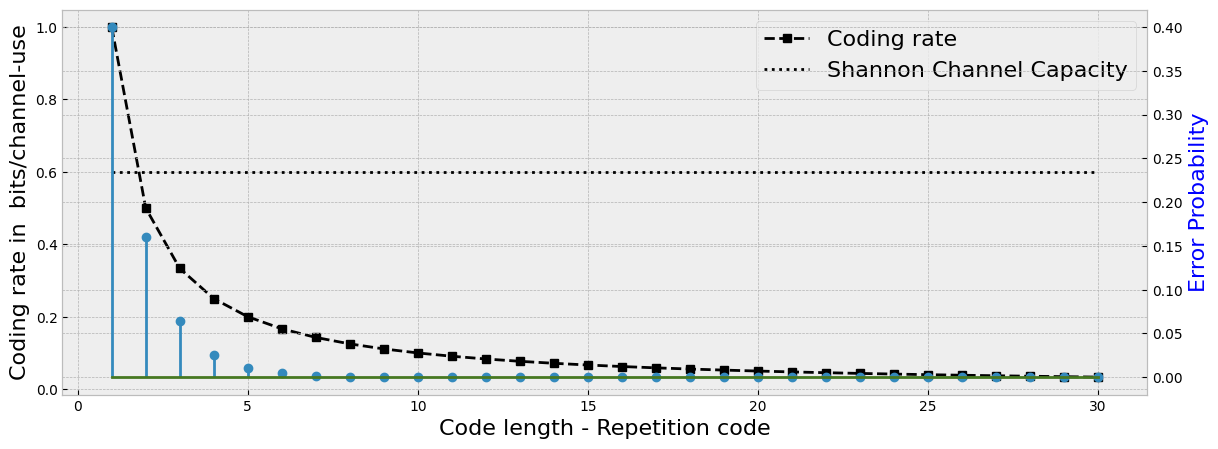

In [7]:
code_length_plot = np.arange(1,31,1)
fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
ax1.plot(code_length_plot, 1/code_length_plot,"ks--", label="Coding rate")
ax1.plot([1,30],[komm.BinaryErasureChannel(p).capacity(),komm.BinaryErasureChannel(p).capacity()] ,"k:",label='Shannon Channel Capacity')
ax2.stem(code_length_plot, p**code_length_plot)
ax1.set_xlabel('Code length - Repetition code',fontsize=16)
ax1.set_ylabel('Coding rate in  bits/channel-use', color='k',fontsize=16)
ax2.set_ylabel('Error Probability', color='b',fontsize=16)
ax1.legend(fontsize=16)
plt.show() 

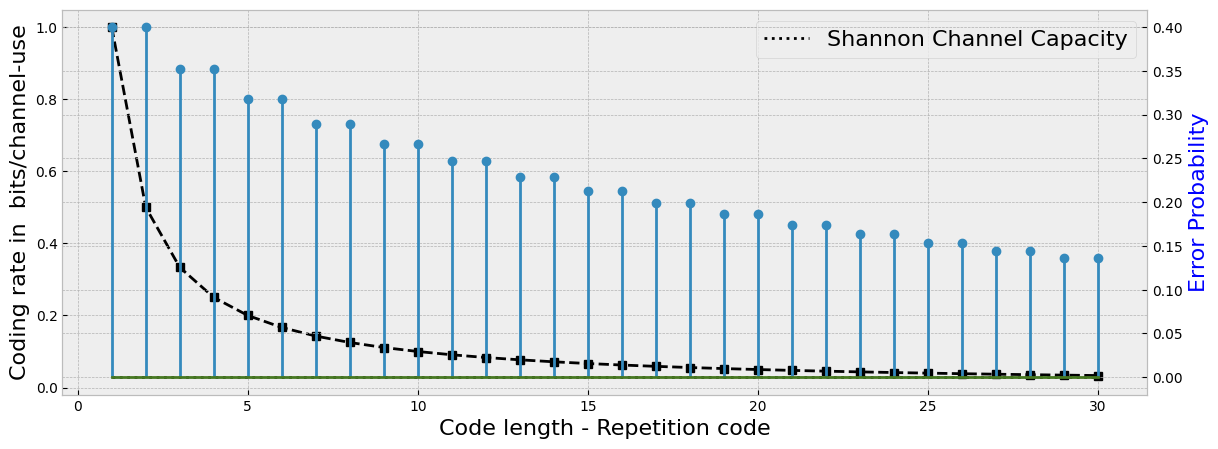

In [8]:
p=0.4
code_length_plot = np.arange(1,31,1)
error_coded_plot = np.zeros(len(code_length_plot))
for i in code_length_plot:
    if i % 2 == 0: ## % is the "mod" function - gives the "rest" in the division
        error_coded_plot[i-1] = 1 - (binom.cdf(i/2 - 1, i, p) + (binom.cdf(i/2, i, p) - binom.cdf(i/2-1, i, p))*0.5)
    else:
        error_coded_plot[i-1]  = 1 - binom.cdf(i/2, i, p)

fig, ax1 = plt.subplots(figsize=(14,5))
ax2 = ax1.twinx()
ax1.plot(code_length_plot, 1/code_length_plot,"ks--")
ax1.plot([1,30],[komm.BinarySymmetricChannel(p).capacity(),komm.BinarySymmetricChannel(p).capacity()] ,"k:",label='Shannon Channel Capacity')
ax2.stem(code_length_plot, error_coded_plot)
ax1.set_xlabel('Code length - Repetition code',fontsize=16)
ax1.set_ylabel('Coding rate in  bits/channel-use', color='k',fontsize=16)
ax2.set_ylabel('Error Probability', color='b',fontsize=16)
ax1.legend(fontsize=16)
plt.show() 

The 1st plot is from the bec channel and the lower plot is from the bsc channel with both having P = 0.4. The bec has way better coding rate compared to the bsc channel. In the bec channel we can see that the channel capacity is reached at just 2 coding length which results to around 16% error rate. To reach the same amount of error probability on bsc we would need to have code length of 24. Also the Shannon Channel Capacity is much much lower on the bsc channel with the higher error probability which means that the channel would need to send a lot of data to keep the data error free. On the bec channel the Shannon channel capacity is 0.6 so the error free communication could be achieved with just around 0.5 coding rate.

**2. Evaluate the performance of the $M$-PSK in relation to Shannon capacity considering the symbol error probability: $$P \approx 2 Q \left(\sqrt{\dfrac{2 E_b \log_2 M}{N_0}} \sin\left(  \dfrac{\pi}{M} \right)  \right).$$**

**Consider the cases of $M=4,8,16$ and plot the figure $P$ versus $E_b/N_0$ in db. Additionally, plot the Shannon capacity vs. $E_b/N_0$.**

**Analyze with your own words the results.**

In [9]:
def Q(x):
    return 1/2*scipy.special.erfc(x/np.sqrt(2))


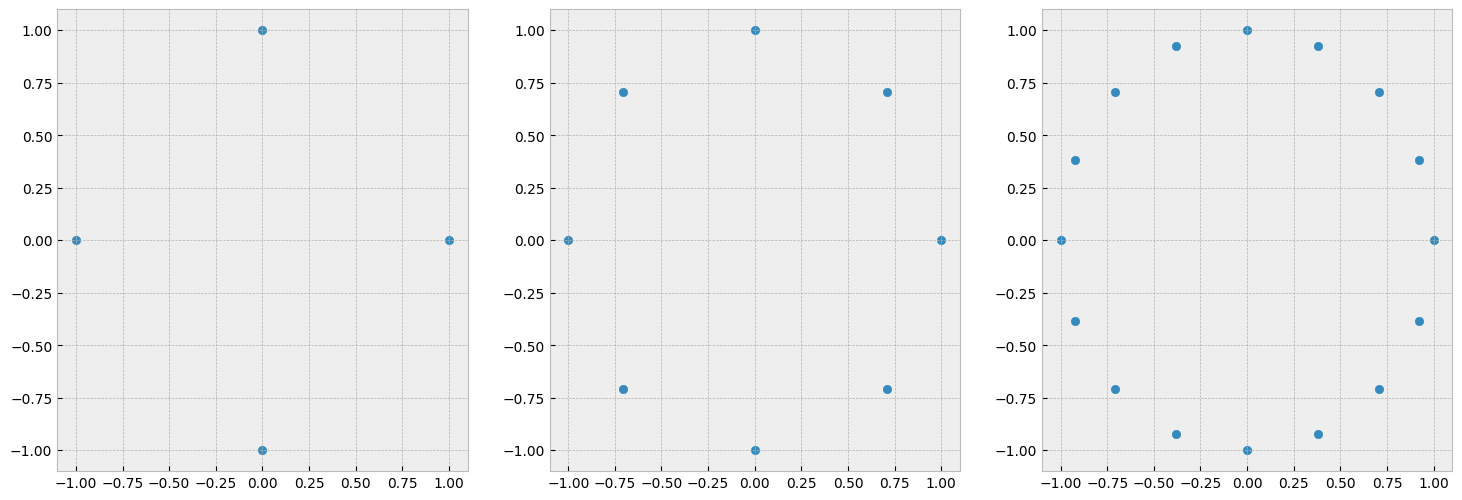

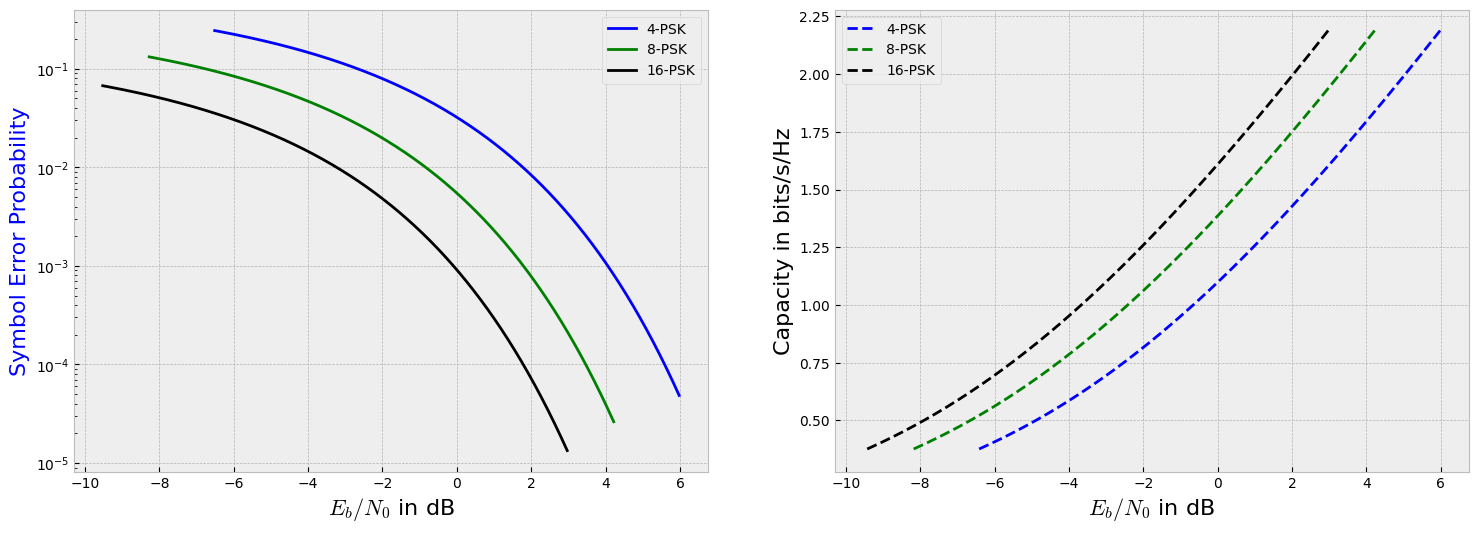

In [10]:

#4-PSK
base_amplitude = 1
noise_power_db_4psk = np.arange(-12, 0.5, 0.01)
noise_power_4psk = 10**(noise_power_db_4psk / 10)
awgn = komm.AWGNChannel()
order = 4
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_4psk  = modulation.energy_per_symbol
awgn.snr_4psk  = awgn.signal_power_4psk  / noise_power_4psk
EbperN0_4psk  = awgn.snr_4psk / modulation.bits_per_symbol
error_probability_4psk  = 2*Q(np.sqrt( 2*EbperN0_4psk*np.log2(order)))*sp.sin(sp.pi / order) 
#
plt.figure(1,figsize=(18,6))
plt.subplot(131)
plt.scatter(modulation.constellation.real,modulation.constellation.imag)

################################
#8-PSK
base_amplitude = 1
noise_power_db_8psk = np.arange(-12, 0.5, 0.01)
noise_power_8psk = 10**(noise_power_db_8psk / 10)
order = 8
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_8psk  = modulation.energy_per_symbol
awgn.snr_8psk  = awgn.signal_power_8psk  / noise_power_8psk
EbperN0_8psk  = awgn.snr_8psk / modulation.bits_per_symbol
error_probability_8psk  = 2*Q(np.sqrt( 2*EbperN0_8psk*np.log2(order)))*sp.sin(sp.pi / order)
#
plt.subplot(132)
plt.scatter(modulation.constellation.real,modulation.constellation.imag)
#
###################################
#16-PSK
base_amplitude = 1
noise_power_db_16psk = np.arange(-12, 0.5, 0.01)
noise_power_16psk = 10**(noise_power_db_16psk / 10)
order = 16
modulation = komm.PSKModulation(order, base_amplitude)
awgn.signal_power_16psk  = modulation.energy_per_symbol
awgn.snr_16psk  = awgn.signal_power_16psk  / noise_power_16psk
EbperN0_16psk  = awgn.snr_16psk / modulation.bits_per_symbol
error_probability_16psk  = 2*Q(np.sqrt( 2*EbperN0_16psk*np.log2(order)))*sp.sin(sp.pi / order)
#
plt.subplot(133)
plt.scatter(modulation.constellation.real,modulation.constellation.imag)
plt.show()
###
plt.figure(1,figsize=(18,6))
plt.subplot(121)
plt.semilogy(10 * np.log10(EbperN0_4psk), error_probability_4psk,'b',label='4-PSK')
plt.semilogy(10 * np.log10(EbperN0_8psk), error_probability_8psk,'g',label='8-PSK')
plt.semilogy(10 * np.log10(EbperN0_16psk), error_probability_16psk,'k',label='16-PSK')
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Symbol Error Probability', color='b',fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(10 * np.log10(EbperN0_4psk), np.log(1+awgn.snr_4psk),'--b',label='4-PSK')
plt.plot(10 * np.log10(EbperN0_8psk), np.log(1+awgn.snr_8psk),'--g',label='8-PSK')
plt.plot(10 * np.log10(EbperN0_16psk), np.log(1+awgn.snr_16psk),'--k',label='16-PSK')
plt.xlabel('$E_b/N_0$ in dB',fontsize=16)
plt.ylabel('Capacity in bits/s/Hz', color='k',fontsize=16)
plt.legend()

From the figures we can see that the 16-PSK produces the best results since the symbol error probability per snr is the lowest and also provides the best capacity per snr out of the three modulation methods. We can also observe that all of the modulations can provide the same amount of capacity in bits/s/Hz but the lower the modulation order the higher the snr needs to be to achieve the same amount of capacity.